In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from addict import Dict

from cadet import Cadet

In [2]:
# macOS installation path
Cadet.cadet_path = '/Users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

In [3]:
# Windows installation path
# Cadet.cadet_path = 'C:/Users/hoang/miniconda3/envs/cadet-env/bin/cadet-cli.exe'

## Exercise 1: Single component Langmuir isotherm with linear gradient

To plot the solid phase concentration as a function of the bulk concentration, we can introduce a linear concentration gradient to the `CSTR` that has an initial concentration of $0~g \cdot L^{-1}$.
For this purpose, we will make use of the `flowrate_filter` function of the `CSTR` (see [here](https://cadet.github.io/interface/unit_operations/cstr.html)).
This way, we can add mass (or particles) to the tank without increasing it's volume.
For this considereation, it is important to assume rapid equilibrium.

***Hint:*** For using the `create_cstr_template()` function, pass the adsorption_model as first argument. 
For the adsorption_parametrers, create a `Dict` and assign the model parameters as keys.
Also, you need to pass a list of binding states for every component.

In [10]:
n_bound = [1]
Q = 1e-3
n_comp = len(n_bound)

cstr_model = Cadet()
cstr_model.root.input.model.nunits = 2

# Adsorption settings
adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.mcl_ka = [3]
adsorption_parameters.mcl_kd = [1]
adsorption_parameters.mcl_qmax = [1]

# INLET
cstr_model.root.input.model.unit_000.unit_type = 'INLET'
cstr_model.root.input.model.unit_000.ncomp = n_comp
cstr_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
cstr_model.root.input.model.unit_001.unit_type = 'CSTR'
cstr_model.root.input.model.unit_001.ncomp = n_comp
cstr_model.root.input.model.unit_001.init_volume = 1e-3
cstr_model.root.input.model.unit_001.porosity = 0.5
cstr_model.root.input.model.unit_001.init_c = n_comp*[0]
cstr_model.root.input.model.unit_001.init_q = n_comp*[0]
cstr_model.root.input.model.unit_001.flow_rate_filter = Q

cstr_model.root.input.model.unit_001.nbound = n_bound
cstr_model.root.input.model.unit_001.adsorption_model = adsorption_model
cstr_model.root.input.model.unit_001.adsorption = adsorption_parameters

# Sections and Switches
cstr_model.root.input.solver.sections.nsec = 1
cstr_model.root.input.solver.sections.section_times = [0.0, 10]

cstr_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[0]
cstr_model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[1]

cstr_model.root.input.model.connections.nswitches = 1
cstr_model.root.input.model.connections.switch_000.section = 0
cstr_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q]


In [11]:
cstr_model.root.input.model.solver.gs_type = 1
cstr_model.root.input.model.solver.max_krylov = 0
cstr_model.root.input.model.solver.max_restarts = 10
cstr_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
cstr_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
cstr_model.root.input.solver.time_integrator.abstol = 1e-6
cstr_model.root.input.solver.time_integrator.algtol = 1e-10
cstr_model.root.input.solver.time_integrator.reltol = 1e-6
cstr_model.root.input.solver.time_integrator.init_step_size = 1e-6
cstr_model.root.input.solver.time_integrator.max_steps = 1000000

In [12]:
# Return data
cstr_model.root.input['return'].split_components_data = 0
cstr_model.root.input['return'].split_ports_data = 0
cstr_model.root.input['return'].unit_000.write_solution_bulk = 1
cstr_model.root.input['return'].unit_000.write_solution_inlet = 1
cstr_model.root.input['return'].unit_000.write_solution_outlet = 1
cstr_model.root.input['return'].unit_000.write_solution_solid = 1

cstr_model.root.input['return'].unit_001 = cstr_model.root.input['return'].unit_000

In [13]:
# Running simulation
cstr_model.filename = 'single-comp-langmuir.h5'
cstr_model.save()

data = cstr_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    cstr_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


Text(0, 0.5, '$c_{solid}$')

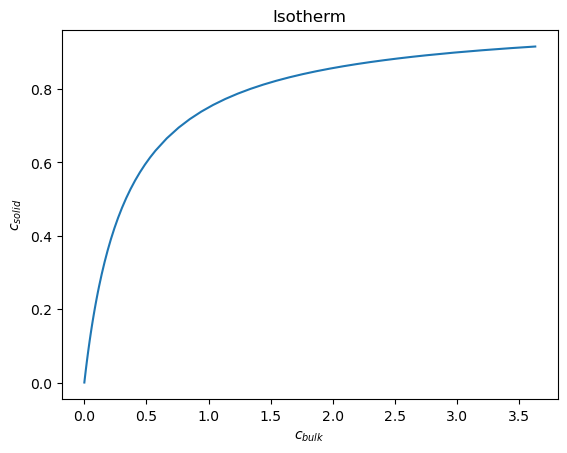

In [14]:
# Plot results
solution_bulk = cstr_model.root.output.solution.unit_001.solution_bulk
solution_solid = cstr_model.root.output.solution.unit_001.solution_solid

plt.figure()
plt.title('Isotherm')
plt.plot(solution_bulk, solution_solid)
plt.xlabel('$c_{bulk}$')
plt.ylabel('$c_{solid}$')

## Exercise 2: Breakthrough curve in a Column

In this example, we look at a column with a `LINEAR` isotherm with $k_{eq, 1} = 2$, and $k_{eq, 2} = 1$.
We want to record the breakthrough curve and for this purpose, a concentration step with $$c_{feed} = [1.0, 1.0]~g \cdot L^{-1} $$is introduced at $t = 0$. 

***Task:*** Implement the configuration for the adsorption isotherm and pass it to the `create_column_template()` function. You also need to provide the number of can also provide

Try experimenting with:
- The binding strenth.
- The number of components.
- Modify how many components bind.
- Compare kinetic binding with rapid equilibrium.

In [26]:
column_model = Cadet()
column_model.root.input.model.nunits = 3

In [38]:
c_feed = [1, 1]
n_bound = [1, 1]
n_comp = len(c_feed)

In [39]:
# Unit Operations
## Inlet
column_model.root.input.model.unit_000.unit_type = 'INLET'
column_model.root.input.model.unit_000.ncomp = n_comp
column_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

column_model.root.input.model.unit_000.sec_000.const_coeff = c_feed

# Tubular reactor
column_model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
column_model.root.input.model.unit_001.ncomp = n_comp
column_model.root.input.model.unit_001.col_length = 0.5
column_model.root.input.model.unit_001.cross_section_area = 0.1
column_model.root.input.model.unit_001.total_porosity = 0.5
column_model.root.input.model.unit_001.par_radius = 1e-6
column_model.root.input.model.unit_001.col_dispersion = 1e-6
column_model.root.input.model.unit_001.init_c = n_comp * [0]
column_model.root.input.model.unit_001.init_q = n_comp * [0]

### Adsorption
adsorption_model = 'LINEAR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.lin_ka = [2,1]
adsorption_parameters.lin_kd = [1,1]
column_model.root.input.model.unit_001.adsorption_model = adsorption_model
column_model.root.input.model.unit_001.adsorption = adsorption_parameters

## Outlet
column_model.root.input.model.unit_002.unit_type = 'OUTLET'
column_model.root.input.model.unit_002.ncomp = n_comp

## Sections and Switches
column_model.root.input.solver.sections.nsec = 1
column_model.root.input.solver.sections.section_times = [0.0, 240]
column_model.root.input.solver.sections.section_continuity = []

column_model.root.input.model.connections.nswitches = 1
column_model.root.input.model.connections.switch_000.section = 0
column_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q,
                                                                1, 2, -1, -1, Q]

In [40]:
column_model.root.input.model.solver.gs_type = 1
column_model.root.input.model.solver.max_krylov = 0
column_model.root.input.model.solver.max_restarts = 10
column_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
column_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
column_model.root.input.solver.time_integrator.abstol = 1e-6
column_model.root.input.solver.time_integrator.algtol = 1e-10
column_model.root.input.solver.time_integrator.reltol = 1e-6
column_model.root.input.solver.time_integrator.init_step_size = 1e-6
column_model.root.input.solver.time_integrator.max_steps = 1000000

In [41]:
# Discretization
# Grid cells
column_model.root.input.model.unit_001.discretization.ncol = 20
column_model.root.input.model.unit_001.discretization.npar = 5
column_model.root.input.model.unit_001.discretization.npartype = 1

# Bound states
column_model.root.input.model.unit_001.discretization.nbound = n_bound

# Other options
column_model.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'
column_model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
column_model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
column_model.root.input.model.unit_001.discretization.gs_type = 1
column_model.root.input.model.unit_001.discretization.max_krylov = 0
column_model.root.input.model.unit_001.discretization.max_restarts = 10
column_model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

# Weno options
column_model.root.input.model.unit_001.discretization.weno.boundary_model = 0
column_model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
column_model.root.input.model.unit_001.discretization.weno.weno_order = 3

In [42]:
# Store solution
column_model.root.input['return'].split_components_data = 0
column_model.root.input['return'].split_ports_data = 0
column_model.root.input['return'].unit_000.write_solution_inlet = 1
column_model.root.input['return'].unit_000.write_solution_outlet = 1
column_model.root.input['return'].unit_000.write_solution_bulk = 1
column_model.root.input['return'].unit_000.write_solution_particle = 1
column_model.root.input['return'].unit_000.write_solution_solid = 1
column_model.root.input['return'].unit_000.write_solution_flux = 1
column_model.root.input['return'].unit_000.write_solution_volume = 1
column_model.root.input['return'].unit_000.write_coordinates = 1
column_model.root.input['return'].unit_000.write_sens_outlet = 1

column_model.root.input['return'].unit_001 = column_model.root.input['return'].unit_000


In [43]:
# Running simulation
column_model.filename = 'breakthrough-curve-column.h5'
column_model.save()

data = column_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    column_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


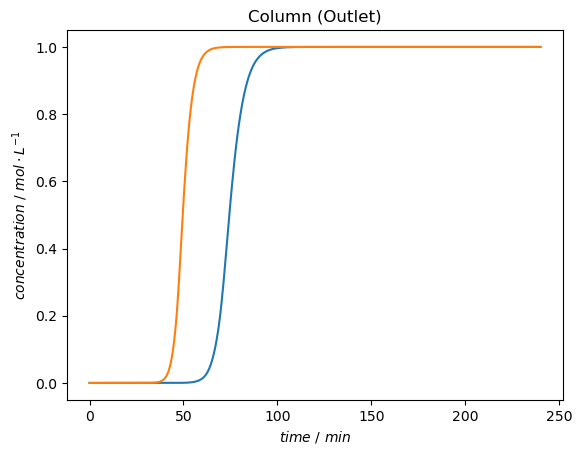

In [44]:
time = column_model.root.output.solution.solution_times
c = column_model.root.output.solution.unit_001.solution_outlet

plt.figure()
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()

## Exercise 3: Langmuir model in Column

Let us consider the same experiment as in the first example, but this time with `MULTI_COMPONENT_LANGMUIR` adsorption model.

with $k_{eq, i} = [2, 1]$, and $q_{max, i} = [10, 10]$.
We again introduce a step with $$c_{feed} = [1.0, 1.0]~g \cdot L^{-1} $$is introduced at $t = 0$ and the breakthrough curve is recorded.

Try experimenting with:
- The binding strenth.
- The number of components.
- Modify how many components bind.
- Compare kinetic binding with rapid equilibrium.

In [47]:
langmuir_model = Cadet()
langmuir_model.root.input.model.nunits = 3

In [48]:
c_feed = [1, 1]
n_bound = [1, 1]
n_comp = len(c_feed)

In [49]:
# Unit Operations
## Inlet
langmuir_model.root.input.model.unit_000.unit_type = 'INLET'
langmuir_model.root.input.model.unit_000.ncomp = n_comp
langmuir_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

langmuir_model.root.input.model.unit_000.sec_000.const_coeff = c_feed

# Tubular reactor
langmuir_model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
langmuir_model.root.input.model.unit_001.ncomp = n_comp
langmuir_model.root.input.model.unit_001.col_length = 0.5
langmuir_model.root.input.model.unit_001.cross_section_area = 0.1
langmuir_model.root.input.model.unit_001.total_porosity = 0.5
langmuir_model.root.input.model.unit_001.par_radius = 1e-6
langmuir_model.root.input.model.unit_001.col_dispersion = 1e-6
langmuir_model.root.input.model.unit_001.init_c = n_comp * [0]
langmuir_model.root.input.model.unit_001.init_q = n_comp * [0]

### Adsorption
adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.mcl_ka = [2,1]
adsorption_parameters.mcl_kd = [1,1]
adsorption_parameters.mcl_qmax = [10,10]
langmuir_model.root.input.model.unit_001.adsorption_model = adsorption_model
langmuir_model.root.input.model.unit_001.adsorption = adsorption_parameters

## Outlet
langmuir_model.root.input.model.unit_002.unit_type = 'OUTLET'
langmuir_model.root.input.model.unit_002.ncomp = n_comp

## Sections and Switches
langmuir_model.root.input.solver.sections.nsec = 1
langmuir_model.root.input.solver.sections.section_times = [0.0, 240]
langmuir_model.root.input.solver.sections.section_continuity = []

langmuir_model.root.input.model.connections.nswitches = 1
langmuir_model.root.input.model.connections.switch_000.section = 0
langmuir_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q,
                                                                1, 2, -1, -1, Q]

In [50]:
langmuir_model.root.input.model.solver.gs_type = 1
langmuir_model.root.input.model.solver.max_krylov = 0
langmuir_model.root.input.model.solver.max_restarts = 10
langmuir_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
langmuir_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
langmuir_model.root.input.solver.time_integrator.abstol = 1e-6
langmuir_model.root.input.solver.time_integrator.algtol = 1e-10
langmuir_model.root.input.solver.time_integrator.reltol = 1e-6
langmuir_model.root.input.solver.time_integrator.init_step_size = 1e-6
langmuir_model.root.input.solver.time_integrator.max_steps = 1000000

In [53]:
# Discretization
# Grid cells
langmuir_model.root.input.model.unit_001.discretization.ncol = 20
langmuir_model.root.input.model.unit_001.discretization.npar = 5
langmuir_model.root.input.model.unit_001.discretization.npartype = 1

# Bound states
langmuir_model.root.input.model.unit_001.discretization.nbound = n_bound

# Other options
langmuir_model.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'
langmuir_model.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
langmuir_model.root.input.model.unit_001.discretization.reconstruction = 'WENO'
langmuir_model.root.input.model.unit_001.discretization.gs_type = 1
langmuir_model.root.input.model.unit_001.discretization.max_krylov = 0
langmuir_model.root.input.model.unit_001.discretization.max_restarts = 10
langmuir_model.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

# Weno options
langmuir_model.root.input.model.unit_001.discretization.weno.boundary_model = 0
langmuir_model.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
langmuir_model.root.input.model.unit_001.discretization.weno.weno_order = 3

In [54]:
# Store solution
langmuir_model.root.input['return'].split_components_data = 0
langmuir_model.root.input['return'].split_ports_data = 0
langmuir_model.root.input['return'].unit_000.write_solution_inlet = 1
langmuir_model.root.input['return'].unit_000.write_solution_outlet = 1
langmuir_model.root.input['return'].unit_000.write_solution_bulk = 1
langmuir_model.root.input['return'].unit_000.write_solution_particle = 1
langmuir_model.root.input['return'].unit_000.write_solution_solid = 1
langmuir_model.root.input['return'].unit_000.write_solution_flux = 1
langmuir_model.root.input['return'].unit_000.write_solution_volume = 1
langmuir_model.root.input['return'].unit_000.write_coordinates = 1
langmuir_model.root.input['return'].unit_000.write_sens_outlet = 1

langmuir_model.root.input['return'].unit_001 = langmuir_model.root.input['return'].unit_000


In [57]:
# Running simulation
langmuir_model.filename = 'breakthrough-curve-column.h5'
langmuir_model.save()

data = langmuir_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    langmuir_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


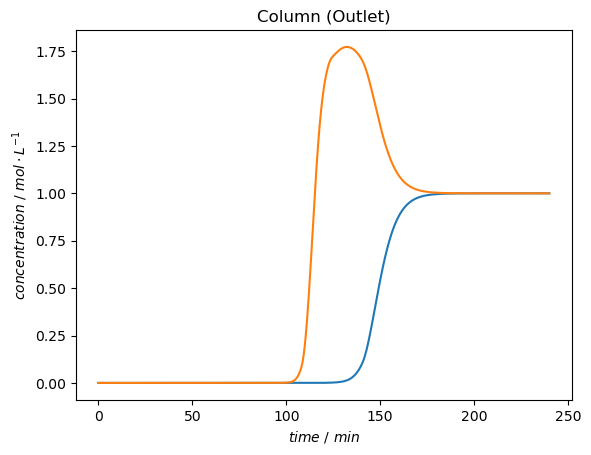

In [56]:
time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_001.solution_outlet

plt.figure()
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()